In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from LDMM import LDMNetSkorch, LDMNetDummy, LDMNetReg, plot_over_time
from sklearn.datasets import make_moons
from prototype_utils import MLPClassifier
from skorch_utils import EarlyStopping, NaNStopping, MLP
from skorch.callbacks import LRScheduler

from sklearn.decomposition import PCA

random_state=0


### On the dummy model
- ksi = X is fixed all the time.
- L and W depend on ksi only, so they remain constant
- Z starts with 0
- Let M = c(L+ cW)^-1 W
- alpha_1 = M ksi
- Z_1 = alpha_1 - ksi
- alpha_2 = M (ksi - Z_1) = M (2*ksi - alpha_1)
- alpha_k+1 = M(2*ksi - alpha_k)
    - linear model x_k+1 = Ax_k + u_k, A = -M
    - eigen values of A all < 1 --> stable
    
### On the reg only model
- ksi starts with X, Z = 0 and alpha ?
- alpha_1 = Mk ksi_0
- ksi_1 = ksi_0 -lr * mu * (ksi_0 - Z_0 + alpha_1)
- Z_1 = Z_0 + alpha_1 - ksi_1
- alpha_1 = Mk ksi_1 - Mk Z_1
- M changes every k because it depends on ksi. If lr is low, ksi and M should not change too much.

## 2 moons data

In [41]:
X, y = make_moons(
        n_samples=200, shuffle=True, noise=None, random_state=random_state)
X = X.astype(np.float32)
y = y.astype(np.int64)

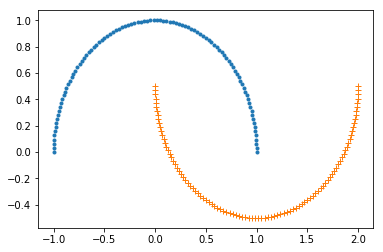

In [42]:
plt.figure()
plt.plot(*X[y==0].T, '.')
plt.plot(*X[y==1].T, '+')

In [75]:
dummy_model = LDMNetDummy(mu=1e-5, lambda_bar=1)

In [76]:
W = dummy_model._compute_W(X)
L = dummy_model._compute_L(W)
c = dummy_model.mu/dummy_model.lambda_bar
# Solve Ax = b
A = (L + c*W).tocsc()
invA = sparse.linalg.spilu(A, drop_tol=1e-5, fill_factor=50)
M = c * invA.solve(W.todense())
np.abs(np.linalg.eigvals(M))[:10], np.all(np.abs(np.linalg.eigvals(M)) < 1.0)

(array([9.99965725e-01, 1.91679683e-01, 1.28596842e-03, 1.28607418e-03,
        3.19697242e-04, 3.18760342e-04, 1.39125286e-04, 1.39123254e-04,
        7.60615301e-05, 7.59921551e-05]), True)

In [77]:
dummy_model.fit(X,y)

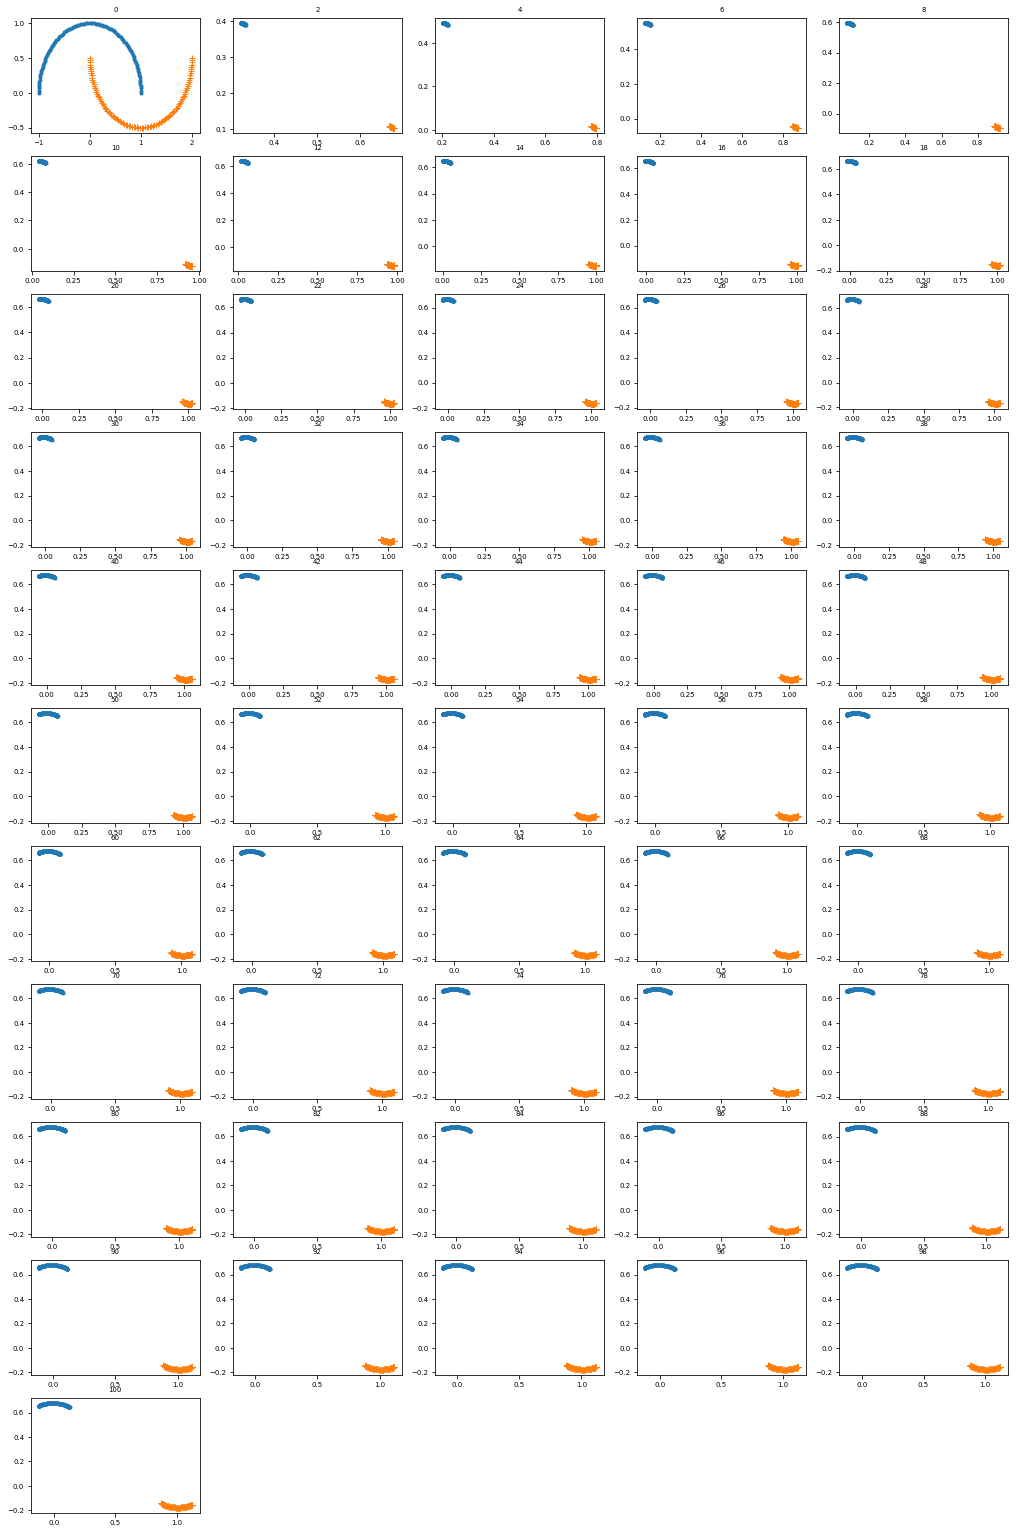

In [78]:
plot_over_time(dummy_model, 'alpha', every_n=2, y=y)

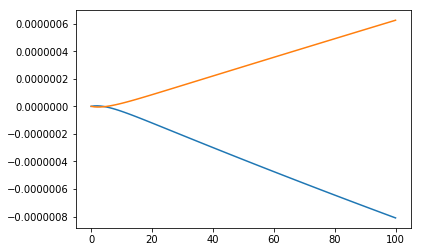

In [79]:
Z = np.stack(dummy_model.Z, axis=-1)
Z = Z.transpose([1,0,2])
plt.figure()
for feature in Z:
    plt.plot(feature.mean(axis=0))

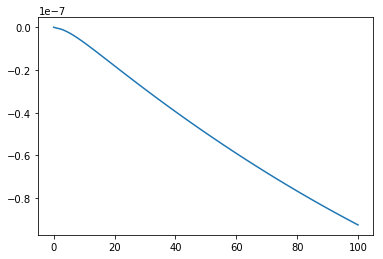

In [80]:
plt.figure()
Zavg = [z.mean() for z in dummy_model.Z]
plt.plot(Zavg)

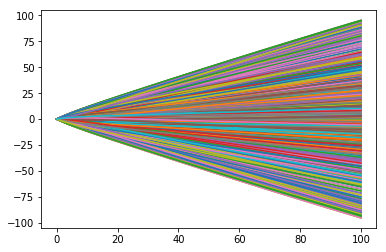

In [81]:
Z = np.stack(dummy_model.Z, axis=-1)
plt.figure()
for sample in Z:
    for feature in sample:
        plt.plot(feature)

### Only reg loss model

In [32]:
reg_model = LDMNetReg(mu=1e-4, lambda_bar=1e0, lr=1)
ksi = reg_model.fit_transform(X,y)

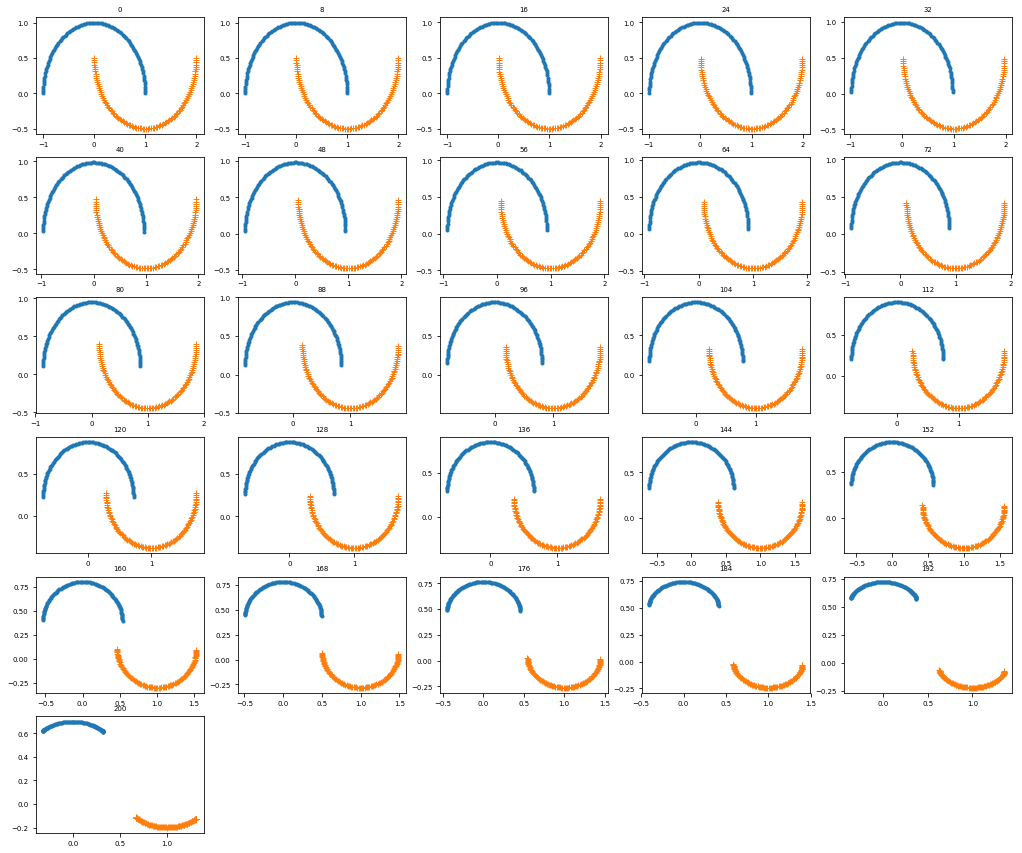

In [33]:
plot_over_time(reg_model, 'ksi', every_n=8, y=y)

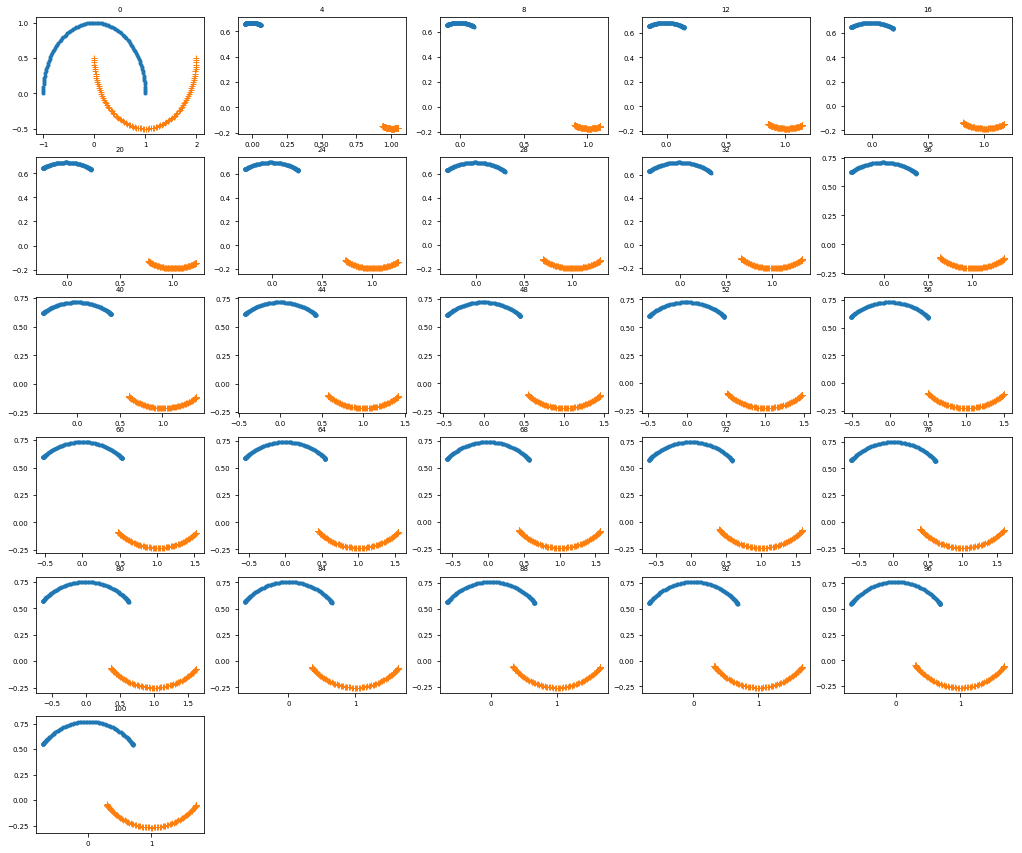

In [34]:
plot_over_time(reg_model, 'alpha', every_n=4)

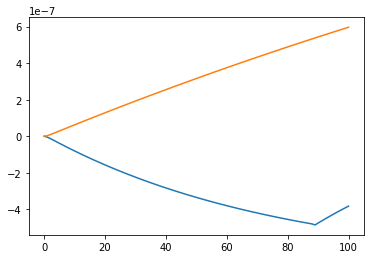

In [35]:
Z = np.stack(reg_model.Z, axis=-1)
Z = Z.transpose([1,0,2])
plt.figure()
for feature in Z:
    plt.plot(feature.mean(axis=0))

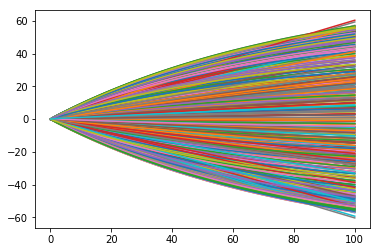

In [36]:
Z = np.stack(reg_model.Z, axis=-1)
plt.figure()
for sample in Z:
    for feature in sample:
        plt.plot(feature)

### MLP model

In [32]:
import torch
from scipy.stats import uniform, reciprocal
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit

torch.manual_seed(random_state)

module = MLP(X.shape[1], 4, 2)
model = LDMNetSkorch(
    module=module,
    layer_name='hidden',
    max_epochs=300,
    batch_size=200,
    lr=0.009,
    mu=0.0003, lambda_bar=0.25,
    use_cuda=True,
    verbose=1,
    callbacks=[EarlyStopping(5, 'valid_loss'),
               NaNStopping()]
)
params = {
'lr': uniform(1e-5, 1e-2),
'mu': reciprocal(1e-5, 1.0),
'lambda_bar': reciprocal(1e-1, 1.0)
}

search = RandomizedSearchCV(
    model, n_iter=5, n_jobs=1,
    cv=StratifiedShuffleSplit(1, test_size=0.2, random_state=random_state),
    refit=True, random_state=random_state,
    param_distributions=params, verbose=1)

In [33]:
search.fit(X,y)
model = search.best_estimator_

Fitting 1 folds for each of 5 candidates, totalling 5 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7385       0.5000        0.7293  0.0203
      2        0.7444       0.5000        0.7287  0.0247
      3        0.7513       0.5000        0.7281  0.0242
      4        0.7453       0.5000        0.7276  0.0254
      5        0.7421       0.5000        0.7271  0.0210
      6        0.7188       0.5000        0.7266  0.0235
      7        0.7263       0.5000        0.7261  0.0202
      8        0.7366       0.5000        0.7256  0.0242
      9        0.7330       0.5000        0.7251  0.0198
     10        0.7390       0.5000        0.7245  0.0238
     11        0.7411       0.5000        0.7240  0.0195
     12        0.7451       0.5000        0.7234  0.0235
     13        0.7396       0.5000        0.7229  0.0207
     14        0.7397       0.5000        0.7223  0.0237
     15        0.7286       0

    122        0.6939       0.5000        0.6806  0.0258
    123        0.6877       0.5000        0.6803  0.0220
    124        0.6883       0.5000        0.6800  0.0272
    125        0.6974       0.5000        0.6797  0.0225
    126        0.6932       0.5312        0.6794  0.0254
    127        0.6883       0.5312        0.6791  0.0208
    128        0.6845       0.5312        0.6788  0.0240
    129        0.6933       0.5938        0.6785  0.0212
    130        0.7000       0.6250        0.6782  0.0273
    131        0.7021       0.6562        0.6779  0.0217
    132        0.6955       0.6875        0.6776  0.0243
    133        0.6892       0.6875        0.6773  0.0218
    134        0.6922       0.6875        0.6771  0.0242
    135        0.6803       0.6875        0.6768  0.0227
    136        0.6762       0.6875        0.6766  0.0269
    137        0.6800       0.6875        0.6763  0.0203
    138        0.6868       0.7188        0.6760  0.0257
    139        0.6972       0.7

    244        0.6553       0.8125        0.6519  0.0245
    245        0.6720       0.8125        0.6517  0.0201
    246        0.6610       0.8125        0.6515  0.0261
    247        0.6589       0.8125        0.6513  0.0196
    248        0.6502       0.8125        0.6511  0.0257
    249        0.6474       0.8125        0.6509  0.0200
    250        0.6415       0.8125        0.6507  0.0249
    251        0.6574       0.8125        0.6505  0.0200
    252        0.6661       0.8125        0.6503  0.0254
    253        0.6387       0.8125        0.6501  0.0250
    254        0.6517       0.8125        0.6499  0.0253
    255        0.6562       0.8125        0.6497  0.0258
    256        0.6630       0.8125        0.6495  0.0267
    257        0.6514       0.8125        0.6493  0.0225
    258        0.6627       0.8125        0.6491  0.0244
    259        0.6556       0.8125        0.6489  0.0230
    260        0.6579       0.8125        0.6487  0.0229
    261        0.6560       0.8

     65        0.7172       0.5000        0.7108  0.0229
     66        0.7273       0.5000        0.7106  0.0262
     67        0.7206       0.5000        0.7103  0.0197
     68        0.7135       0.5000        0.7100  0.0282
     69        0.7133       0.5000        0.7098  0.0197
     70        0.7250       0.5000        0.7095  0.0277
     71        0.7154       0.5000        0.7093  0.0202
     72        0.7252       0.5000        0.7090  0.0253
     73        0.7162       0.5000        0.7088  0.0284
     74        0.7243       0.5000        0.7085  0.0270
     75        0.7201       0.5000        0.7083  0.0211
     76        0.7088       0.5000        0.7081  0.0231
     77        0.7237       0.5000        0.7079  0.0238
     78        0.7286       0.5000        0.7076  0.0272
     79        0.7096       0.5000        0.7074  0.0259
     80        0.7012       0.5000        0.7072  0.0262
     81        0.7148       0.5000        0.7069  0.0210
     82        0.7274       0.5

    189        0.6813       0.5000        0.6841  0.0288
    190        0.7135       0.5000        0.6839  0.0239
    191        0.7028       0.5000        0.6837  0.0198
    192        0.6995       0.5000        0.6835  0.0265
    193        0.6830       0.5000        0.6834  0.0303
    194        0.6925       0.5000        0.6832  0.0323
    195        0.6987       0.5000        0.6830  0.0284
    196        0.6940       0.5000        0.6828  0.0278
    197        0.6923       0.5000        0.6827  0.0203
    198        0.6945       0.5000        0.6825  0.0276
    199        0.6960       0.5000        0.6823  0.0290
    200        0.6851       0.5000        0.6821  0.0311
    201        0.6833       0.5000        0.6819  0.0303
    202        0.6995       0.5000        0.6818  0.0266
    203        0.6986       0.5000        0.6816  0.0201
    204        0.6920       0.5000        0.6814  0.0256
    205        0.6880       0.5000        0.6812  0.0218
    206        0.6880       0.5

      9        0.7559       0.5000        0.7240  0.0217
     10        0.7420       0.5000        0.7234  0.0231
     11        0.7360       0.5000        0.7229  0.0284
     12        0.7549       0.5000        0.7222  0.0305
     13        0.7350       0.5000        0.7217  0.0262
     14        0.7363       0.5000        0.7212  0.0371
     15        0.7427       0.5000        0.7209  0.0274
     16        0.7368       0.5000        0.7202  0.0275
     17        0.7460       0.5000        0.7200  0.0267
     18        0.7339       0.5000        0.7194  0.0297
     19        0.7363       0.5000        0.7194  0.0214
     20        0.7270       0.5000        0.7188  0.0280
     21        0.7435       0.5000        0.7190  0.0201
     22        0.7448       0.5000        0.7184  0.0228
     23        0.7361       0.5000        0.7191  0.0320
     24        0.7212       0.5000        0.7186  0.0300
     25        0.7357       0.5000        0.7197  0.0292
     26        0.7392       0.5

    103        0.6855       0.5000        0.6830  0.0205
    104        0.6838       0.5000        0.6827  0.0266
    105        0.6806       0.5000        0.6823  0.0202
    106        0.6924       0.5000        0.6819  0.0320
    107        0.6986       0.5000        0.6815  0.0199
    108        0.6996       0.5000        0.6812  0.0328
    109        0.6949       0.5000        0.6808  0.0199
    110        0.6804       0.5000        0.6805  0.0327
    111        0.6936       0.5000        0.6802  0.0199
    112        0.6806       0.5000        0.6798  0.0273
    113        0.7013       0.5000        0.6796  0.0323
    114        0.6898       0.5312        0.6792  0.0329
    115        0.6980       0.5312        0.6789  0.0291
    116        0.6910       0.5625        0.6786  0.0311
    117        0.6942       0.6250        0.6782  0.0287
    118        0.6911       0.6562        0.6779  0.0307
    119        0.6981       0.6875        0.6776  0.0291
    120        0.6915       0.6

    224        0.6718       0.8125        0.6512  0.0236
    225        0.6725       0.8125        0.6510  0.0201
    226        0.6749       0.8125        0.6508  0.0262
    227        0.6573       0.8125        0.6506  0.0199
    228        0.6635       0.8125        0.6503  0.0262
    229        0.6561       0.8125        0.6501  0.0201
    230        0.6476       0.8125        0.6499  0.0265
    231        0.6671       0.8125        0.6497  0.0204
    232        0.6574       0.8125        0.6495  0.0269
    233        0.6504       0.8125        0.6492  0.0206
    234        0.6497       0.8125        0.6490  0.0254
    235        0.6607       0.8125        0.6488  0.0200
    236        0.6467       0.8125        0.6485  0.0275
    237        0.6669       0.8125        0.6483  0.0204
    238        0.6679       0.8125        0.6481  0.0260
    239        0.6685       0.8125        0.6479  0.0201
    240        0.6641       0.8125        0.6477  0.0256
    241        0.6548       0.8

     45        0.7267       0.5000        0.7028  0.0215
     46        0.7165       0.5000        0.7023  0.0253
     47        0.7099       0.5000        0.7018  0.0216
     48        0.7118       0.5000        0.7012  0.0260
     49        0.7057       0.5000        0.7007  0.0230
     50        0.7202       0.5000        0.7001  0.0256
     51        0.7143       0.5000        0.6996  0.0329
     52        0.7118       0.5000        0.6991  0.0301
     53        0.7192       0.5000        0.6987  0.0234
     54        0.7183       0.5000        0.6982  0.0244
     55        0.7147       0.5000        0.6977  0.0214
     56        0.7022       0.5000        0.6972  0.0244
     57        0.7118       0.5000        0.6967  0.0198
     58        0.7036       0.5000        0.6963  0.0255
     59        0.7125       0.5000        0.6959  0.0268
     60        0.7081       0.5000        0.6954  0.0274
     61        0.7119       0.5000        0.6949  0.0203
     62        0.7128       0.5

    166        0.6706       0.8438        0.6583  0.0249
    167        0.6653       0.8438        0.6580  0.0195
    168        0.6679       0.8438        0.6577  0.0267
    169        0.6612       0.8438        0.6575  0.0198
    170        0.6603       0.8438        0.6572  0.0259
    171        0.6673       0.8438        0.6569  0.0212
    172        0.6673       0.8438        0.6567  0.0251
    173        0.6508       0.8438        0.6564  0.0199
    174        0.6608       0.8438        0.6562  0.0255
    175        0.6823       0.8438        0.6560  0.0195
    176        0.6743       0.8438        0.6557  0.0268
    177        0.6559       0.8438        0.6555  0.0203
    178        0.6769       0.8438        0.6553  0.0264
    179        0.6644       0.8438        0.6550  0.0195
    180        0.6611       0.8438        0.6548  0.0254
    181        0.6634       0.8438        0.6545  0.0200
    182        0.6597       0.8438        0.6542  0.0258
    183        0.6678       0.8

    290        0.6236       0.8125        0.6248  0.0238
    291        0.6382       0.8125        0.6245  0.0201
    292        0.6504       0.8125        0.6243  0.0259
    293        0.6242       0.8125        0.6240  0.0201
    294        0.6250       0.8125        0.6237  0.0257
    295        0.6415       0.8125        0.6235  0.0206
    296        0.6272       0.8125        0.6232  0.0273
    297        0.6375       0.8125        0.6229  0.0231
    298        0.6433       0.8125        0.6226  0.0271
    299        0.6459       0.8125        0.6224  0.0210
    300        0.6242       0.8125        0.6221  0.0268


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7485       0.5000        0.7304  0.0311
      2        0.7409       0.5000        0.7298  0.0314
      3        0.7309       0.5000        0.7292  0.0243
      4        0.7422       0.5000        0.7285  0.0315
      5        0.7458       0.5000        0.7280  0.0250
      6        0.7520       0.5000        0.7273  0.0311
      7        0.7388       0.5000        0.7268  0.0269
      8        0.7477       0.5000        0.7261  0.0312
      9        0.7489       0.5000        0.7255  0.0248
     10        0.7310       0.5000        0.7250  0.0328
     11        0.7239       0.5000        0.7246  0.0252
     12        0.7285       0.5000        0.7241  0.0333
     13        0.7370       0.5000        0.7236  0.0252
     14        0.7300       0.5000        0.7231  0.0312
     15        0.7376       0.5000        0.7226  0.0254
     16        0.7275       0.5

    121        0.6890       0.5750        0.6800  0.0243
    122        0.6971       0.6000        0.6797  0.0314
    123        0.6904       0.6000        0.6794  0.0244
    124        0.6940       0.6000        0.6791  0.0312
    125        0.6980       0.6000        0.6788  0.0244
    126        0.6910       0.6000        0.6785  0.0305
    127        0.6959       0.6000        0.6782  0.0244
    128        0.6900       0.6000        0.6779  0.0324
    129        0.6829       0.6250        0.6776  0.0245
    130        0.6905       0.6500        0.6773  0.0319
    131        0.6928       0.6500        0.6771  0.0247
    132        0.6826       0.6500        0.6768  0.0299
    133        0.6874       0.6500        0.6765  0.0250
    134        0.6909       0.6750        0.6762  0.0318
    135        0.6859       0.6750        0.6760  0.0250
    136        0.6898       0.6750        0.6757  0.0326
    137        0.6887       0.7000        0.6754  0.0244
    138        0.6749       0.7

    242        0.6592       0.8500        0.6505  0.0316
    243        0.6646       0.8500        0.6503  0.0250
    244        0.6492       0.8500        0.6501  0.0747
    245        0.6575       0.8500        0.6499  0.0239
    246        0.6496       0.8500        0.6496  0.0327
    247        0.6639       0.8500        0.6494  0.0255
    248        0.6631       0.8500        0.6492  0.0326
    249        0.6546       0.8500        0.6490  0.0341
    250        0.6620       0.8500        0.6488  0.0359
    251        0.6619       0.8500        0.6486  0.0361
    252        0.6589       0.8500        0.6484  0.0395
    253        0.6678       0.8500        0.6482  0.0281
    254        0.6496       0.8500        0.6480  0.0310
    255        0.6611       0.8500        0.6478  0.0256
    256        0.6537       0.8500        0.6476  0.0311
    257        0.6626       0.8500        0.6474  0.0247
    258        0.6561       0.8500        0.6472  0.0319
    259        0.6517       0.8

In [34]:
search.best_params_

{'lambda_bar': 0.24179177243329458,
 'lr': 0.007927250380826645,
 'mu': 0.004410365667970986}

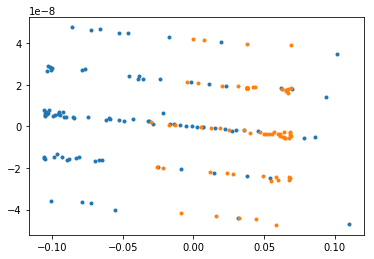

In [35]:
ksi = model.transform(X)
y_pred = model.predict(X)
from sklearn.decomposition import PCA
ksi2d = PCA(n_components=2).fit_transform(ksi)
plt.figure()
plt.plot(*ksi2d[y==0].T, '.')
plt.plot(*ksi2d[y==1].T, '.')

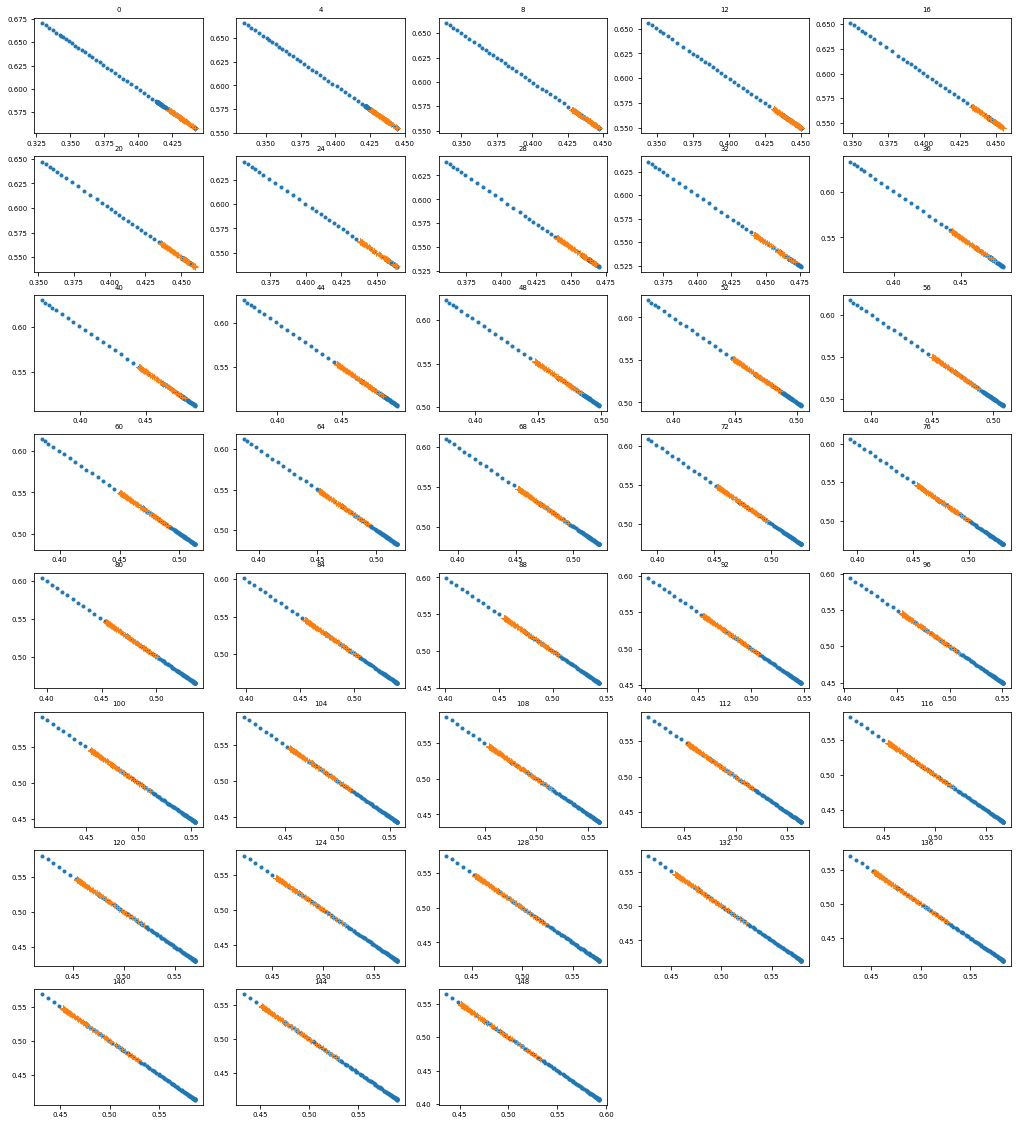

In [28]:
plot_over_time(model, 'ksi', every_n=4, y=y)

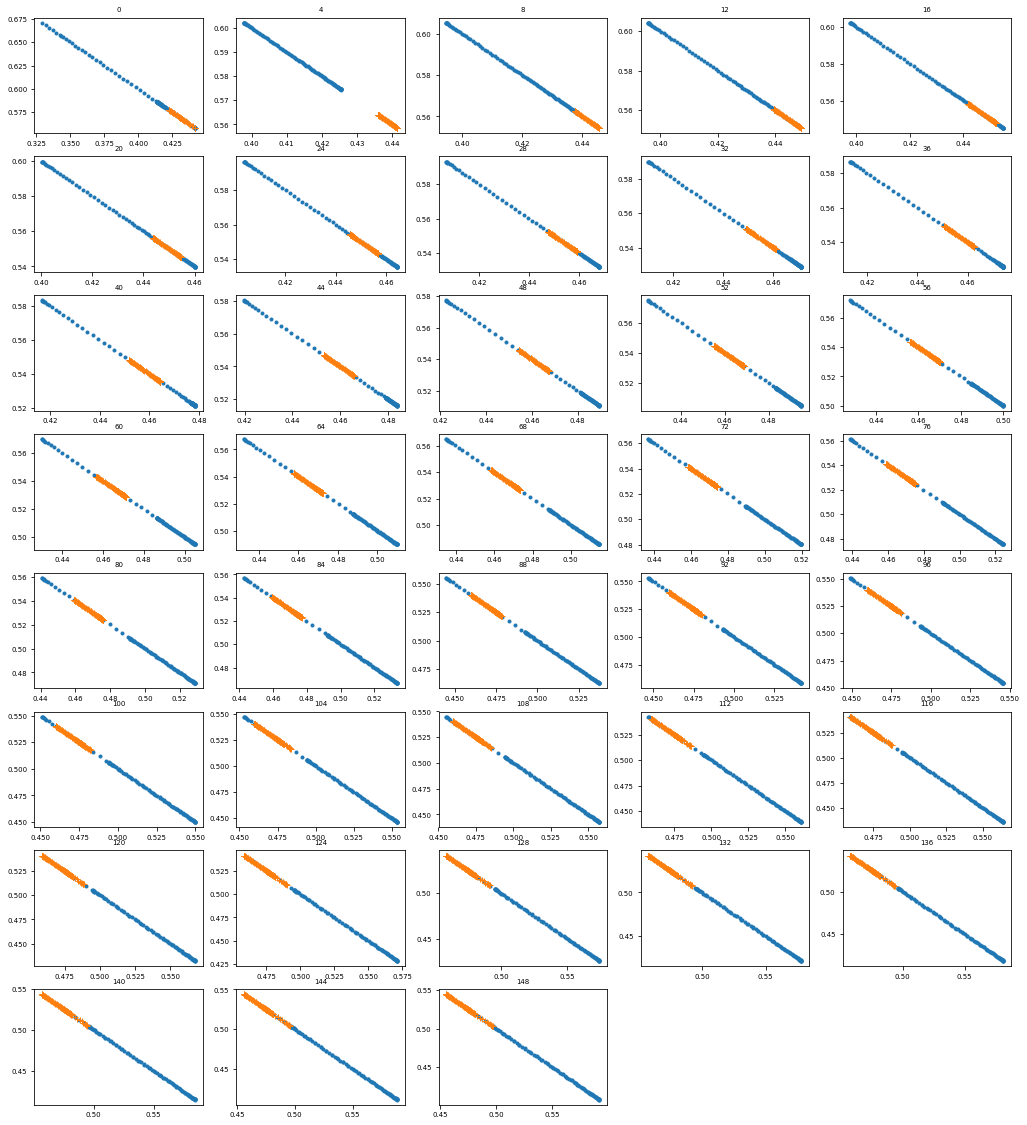

In [29]:
plot_over_time(model, 'alpha', every_n=4, y=y)

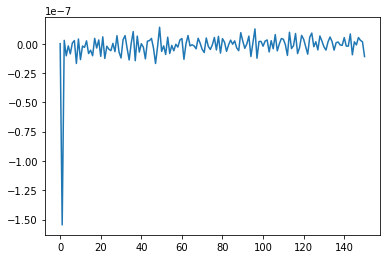

In [30]:
plt.figure()
Zavg = [z.mean() for z in model.Z]
plt.plot(Zavg)

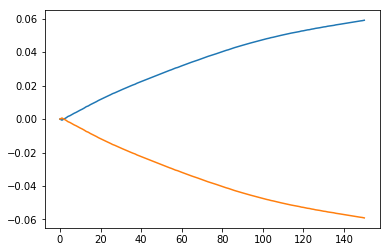

In [31]:
Z = np.stack(model.Z, axis=-1)
Z = Z.transpose([1,0,2])
plt.figure()
for feature in Z:
    plt.plot(feature.mean(axis=0))